In [6]:
# Simple Model
class HelloModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(OrderedDict([
        ("conv1",nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3, padding=1)),
        ("relu1",nn.ReLU()),
        ("s1",nn.MaxPool2d(kernel_size=2,stride=2)),
        ("conv2",nn.Conv2d(16, 32, kernel_size=3, padding=1)),
        ("relu2",nn.ReLU()),
        ("s2",nn.MaxPool2d(kernel_size=2,stride=2))
    ]))

    self.classifier = nn.Sequential(OrderedDict([
        ("fc1",nn.Linear(in_features=32 * 7 * 7, out_features=128)),
        ("fc2",nn.Linear(in_features=128,out_features=10))
        ]))


  def forward(self,x):
    x = self.net(x)
    x = x.view(-1, 32 * 7 * 7)
    return self.classifier(x)


In [32]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data/mnist',train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset)) # 80% of the dataset in training
val_size = len(dataset) - train_size # 20% of the dataset in validation

data_train,data_val = random_split(dataset,[train_size,val_size],generator=torch.Generator().manual_seed(42))
data_train_loader = DataLoader(data_train,batch_size = 64, shuffle=True,num_workers=0)
data_val_loader = DataLoader(data_val,batch_size=64,shuffle=False,num_workers=0)

In [37]:
def train(model,train_loader,val_loader,criterion,optimizer,start_epoch=0,num_epochs = 10,checkpoint_path="checkpoint.pth"):
  best_loss = float('inf')
  for epoch in range(start_epoch,num_epochs):
    model.train()
    train_loss = 0.0

    for images,classes in train_loader:
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output,classes)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)

    #Validation from here
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
      for images,labels in val_loader:
          output = model(images)
          loss = criterion(output,labels)
          val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_loss:
      best_loss = val_loss
      torch.save({
          "epoch":epoch+1,
          "model_state_dict":model.state_dict(),
          "optimizer_state_dict":optimizer.state_dict(),
          "loss":val_loss
      },checkpoint_path)
      print(f"Saved best model at epoch {epoch + 1} with loss {best_loss:.4f}")
    else:
      print(f"Skipping save at epoch {epoch + 1} as loss did not improve")



In [2]:
def load_checkpoint(model,optimizer,checkpoint_path):
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  start_epoch = checkpoint["epoch"]
  print(f"Resuming from epoch {start_epoch}, Best Loss: {checkpoint['loss']:.4f}")
  return start_epoch

In [40]:
def test(model,test_loader,criterion,checkpoint_path):
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint["model_state_dict"])
  model.eval()

  test_loss = 0.0
  total = 0.0
  correct = 0.0

  with torch.no_grad():
    for images,labels in test_loader:
      output = model(images)
      loss = criterion(output,labels)
      test_loss += loss.item()
      predicted = output.detach().max(1)[1]
      # _,predicted = torch.max(output,1)
      correct += predicted.eq(labels.view_as(predicted)).sum()
      total += labels.size(0)

  test_loss /= len(test_loader)
  accuracy = correct / total
  print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


In [39]:
data_test = datasets.MNIST('./data/mnist',download=True,train=False,transform=transform)
data_test_loader = DataLoader(data_test,batch_size = 64, shuffle=False,num_workers=0)

In [38]:
model = HelloModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

import os
if os.path.exists("checkpoint.pth"):
  start_epoch = load_checkpoint(model,optimizer,"checkpoint.pth")
else:
  start_epoch = 0

train(model,data_train_loader,data_val_loader,criterion,optimizer,start_epoch,10,"checkpoint.pth")


Epoch 1: Train Loss = 0.2255, Val Loss = 0.0909
Saved best model at epoch 1 with loss 0.0909
Epoch 2: Train Loss = 0.0681, Val Loss = 0.0686
Saved best model at epoch 2 with loss 0.0686
Epoch 3: Train Loss = 0.0479, Val Loss = 0.0618
Saved best model at epoch 3 with loss 0.0618
Epoch 4: Train Loss = 0.0404, Val Loss = 0.0595
Saved best model at epoch 4 with loss 0.0595
Epoch 5: Train Loss = 0.0340, Val Loss = 0.0515
Saved best model at epoch 5 with loss 0.0515
Epoch 6: Train Loss = 0.0290, Val Loss = 0.0517
Skipping save at epoch 6 as loss did not improve
Epoch 7: Train Loss = 0.0230, Val Loss = 0.0525
Skipping save at epoch 7 as loss did not improve
Epoch 8: Train Loss = 0.0218, Val Loss = 0.0567
Skipping save at epoch 8 as loss did not improve
Epoch 9: Train Loss = 0.0170, Val Loss = 0.0519
Skipping save at epoch 9 as loss did not improve
Epoch 10: Train Loss = 0.0171, Val Loss = 0.0450
Saved best model at epoch 10 with loss 0.0450


In [42]:
test(model,data_test_loader,criterion,"checkpoint.pth")

<ipython-input-40-aca585d07075>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Test Loss: 0.0360, Accuracy: 0.9890


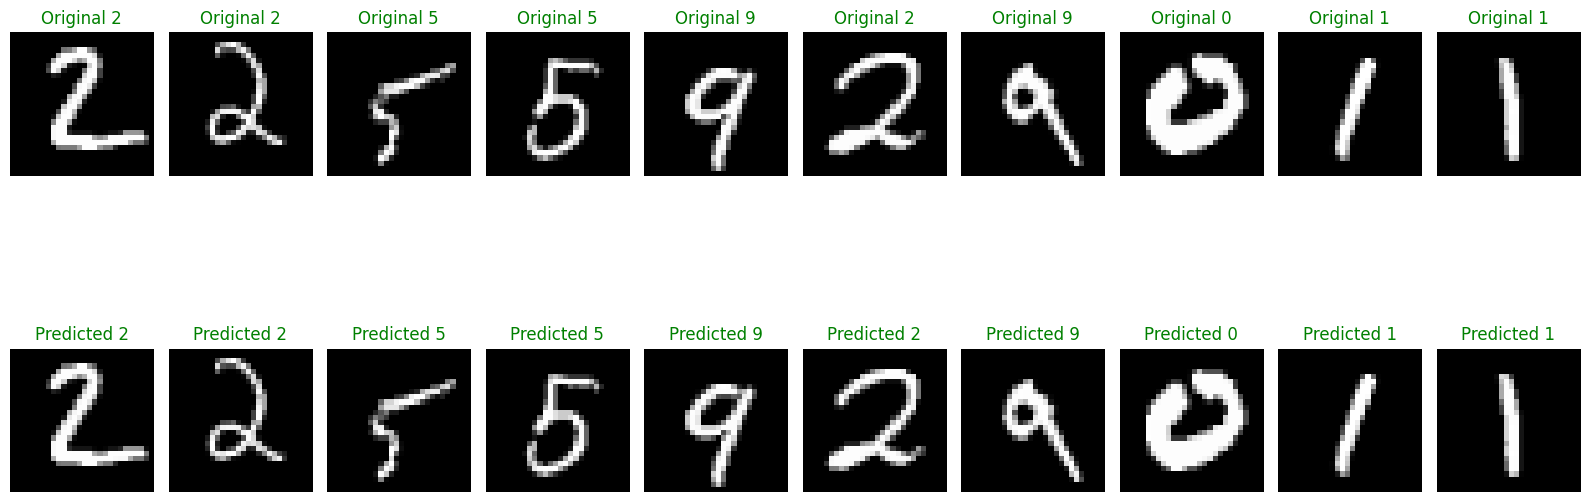

In [64]:
from matplotlib import pyplot as plt

images,labels = next(iter(data_test_loader))
output = model(images)
predict = output.detach().max(1)[1]
random_indices = torch.randperm(len(images))[:10]

fig,axes = plt.subplots(2,10,figsize=(16,8))

with torch.no_grad():
  for idx,rand_idx in enumerate(random_indices):
    ax_original = axes[0,idx]
    ax_predicted = axes[1,idx]

    ax_original.imshow(images[rand_idx].squeeze(),cmap="gray")
    ax_original.set_title(f"Original {labels[rand_idx].item()}", color="green")
    ax_original.axis('off')

    ax_predicted.imshow(images[rand_idx].squeeze(),cmap="gray")
    ax_predicted.set_title(f"Predicted {predict[rand_idx].item()}",color = "green" if labels[rand_idx].item() == predict[rand_idx].item() else "red")
    ax_predicted.axis('off')

  fig.tight_layout()
  plt.show()